In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model,Sequential 
from keras.layers import Dense, Dropout, LSTM, Input, Activation, RepeatVector, TimeDistributed
from keras.layers import LSTM, GRU
from keras import optimizers
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
# import all stock prices
df_stock = pd.read_csv("NASDAQ_Composite_2020.csv", index_col = 0)
df_stock.head()

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted
TIMESTAMP,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,1.931380e+09,2308.419922
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2.367860e+09,2308.709961
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2.253340e+09,2301.090088
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2.270050e+09,2300.050049
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2.145390e+09,2317.169922


In [3]:
# ICE BofA US High Yield Index Option-Adjusted Spread
df_interest_rate = pd.read_csv("BAMLH0A0HYM2_2020.csv", index_col = 0)
df_interest_rate.head()

,BAMLH0A0HYM2
DATE,
2010-01-04,6.34
2010-01-05,6.30
2010-01-06,6.17
2010-01-07,6.03
2010-01-08,6.02


In [4]:
# Replace the bad value with value nearby
df_interest_rate.loc[df_interest_rate.BAMLH0A0HYM2 == '.'] = np.nan
df_interest_rate[['BAMLH0A0HYM2']] = df_interest_rate[['BAMLH0A0HYM2']].apply(pd.to_numeric)
df_interest_rate['BAMLH0A0HYM2'].interpolate(method='linear', inplace=True)
df_interest_rate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2724 entries, 2010-01-04 to 2020-04-23
Data columns (total 1 columns):
BAMLH0A0HYM2    2724 non-null float64
dtypes: float64(1)
memory usage: 42.6+ KB


In [5]:
set_stock_dates = set(df_stock.index)
set_rate_dates = set(df_interest_rate.index)

# Take the difference between the sets and print
print(set_stock_dates - set_rate_dates)

set()


In [6]:
# Merge stocks and bonds DataFrames using join()
df = df_stock.join(df_interest_rate, how='left')
df.head(10)

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted,BAMLH0A0HYM2
TIMESTAMP,,,,,,,
2010-01-04,2294.409912,2311.149902,2294.409912,2308.419922,1.931380e+09,2308.419922,6.34
2010-01-05,2307.270020,2313.729980,2295.620117,2308.709961,2.367860e+09,2308.709961,6.30
2010-01-06,2307.709961,2314.070068,2295.679932,2301.090088,2.253340e+09,2301.090088,6.17
2010-01-07,2298.090088,2301.300049,2285.219971,2300.050049,2.270050e+09,2300.050049,6.03
2010-01-08,2292.239990,2317.600098,2290.610107,2317.169922,2.145390e+09,2317.169922,6.02
2010-01-11,2324.780029,2326.280029,2302.209961,2312.409912,2.077890e+09,2312.409912,5.99
2010-01-12,2297.280029,2298.850098,2272.699951,2282.310059,2.368320e+09,2282.310059,6.07
2010-01-13,2289.459961,2313.030029,2274.120117,2307.899902,2.318350e+09,2307.899902,6.03
2010-01-14,2303.310059,2322.560059,2303.290039,2316.739990,2.254170e+09,2316.739990,6.04


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2593 entries, 2010-01-04 to 2020-04-22
Data columns (total 7 columns):
IXIC.Open        2593 non-null float64
IXIC.High        2593 non-null float64
IXIC.Low         2593 non-null float64
IXIC.Close       2593 non-null float64
IXIC.Volume      2593 non-null float64
IXIC.Adjusted    2593 non-null float64
BAMLH0A0HYM2     2593 non-null float64
dtypes: float64(7)
memory usage: 242.1+ KB


In [8]:
df.describe()

,IXIC.Open,IXIC.High,IXIC.Low,IXIC.Close,IXIC.Volume,IXIC.Adjusted,BAMLH0A0HYM2
count,2593.000000,2593.000000,2593.000000,2593.000000,2.593000e+03,2593.000000,2593.000000
mean,4858.828091,4886.134864,4829.059978,4860.014423,2.005887e+09,4860.014423,5.017287
std,1970.486621,1982.172142,1958.370492,1971.059765,4.843813e+08,1971.059765,1.286155
min,2099.659912,2110.659912,2061.139893,2091.790039,1.494100e+08,2091.790039,3.160000
25%,3000.439941,3012.949951,2975.979980,2991.219971,1.740430e+09,2991.219971,3.930000
50%,4690.930176,4715.810059,4655.720215,4688.540039,1.926110e+09,4688.540039,4.740000
75%,6442.169922,6460.839844,6416.299805,6453.259766,2.166470e+09,6453.259766,5.940000
max,9799.200195,9838.370117,9777.099609,9817.179688,5.301170e+09,9817.179688,10.870000


In [9]:
df_train = df['2010-01-01':'2018-12-31']
df_test = df['2019-01-01':'2019-12-31']
df_valid =  df['2020-01-01':]
print('Length of data from Jan 2010 to Dec 2018 is', df_train.shape[0])
print('Length of data from Jan 2019 to Dec 2019 is', df_test.shape[0])
print('Length of data from Jan 2020 to April 2020 is', df_valid.shape[0])

Length of data from Jan 2010 to Dec 2018 is 2264
Length of data from Jan 2019 to Dec 2019 is 252
Length of data from Jan 2020 to April 2020 is 77


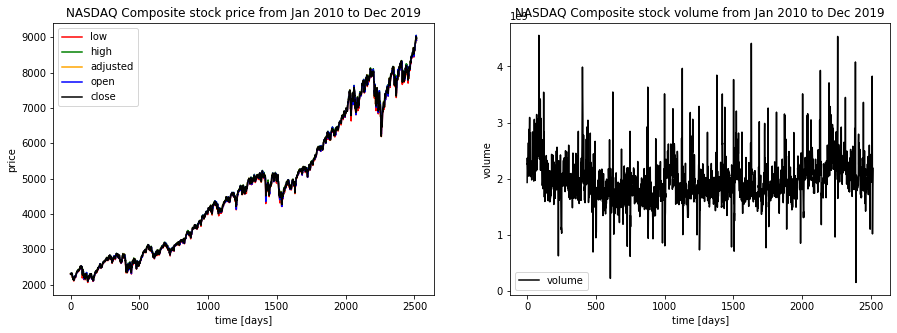

In [10]:
df_plot = df['2010-01-01':'2019-12-31']
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(df_plot['IXIC.Low'].values, color='red', label='low')
plt.plot(df_plot['IXIC.High'].values, color='green', label='high')
plt.plot(df_plot['IXIC.Adjusted'].values, color='orange', label='adjusted')
plt.plot(df_plot['IXIC.Open'].values, color='blue', label='open')
plt.plot(df_plot['IXIC.Close'].values, color='black', label='close')
plt.title('NASDAQ Composite stock price from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')


plt.subplot(1,2,2)
plt.plot(df_plot['IXIC.Volume'].values, color='black', label='volume')
plt.title('NASDAQ Composite stock volume from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

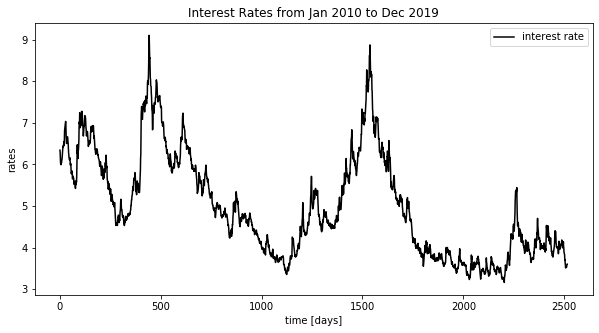

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(df_plot.BAMLH0A0HYM2.values, color='black', label='interest rate')
plt.title('Interest Rates from Jan 2010 to Dec 2019')
plt.xlabel('time [days]')
plt.ylabel('rates')
plt.legend(loc='best')

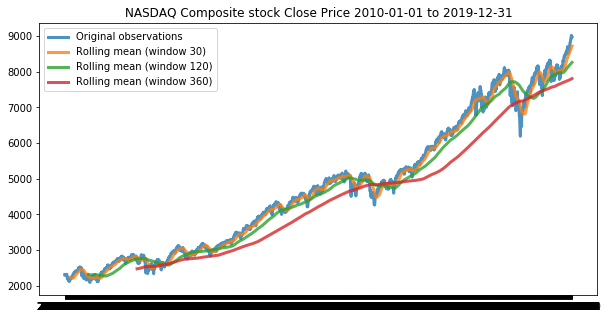

In [12]:
# Moving average
close = df_plot['IXIC.Close']
MA30 = close.rolling(window=30).mean()
MA120 = close.rolling(window=120).mean()
MA360 = close.rolling(window=360).mean()
plt.figure(figsize=(10, 5))
plt.plot(close.index, close, lw=3, alpha=0.8, label='Original observations')
plt.plot(close.index, MA30, lw=3, alpha=0.8, label='Rolling mean (window 30)')
plt.plot(close.index, MA120, lw=3, alpha=0.8, label='Rolling mean (window 120)')
plt.plot(close.index, MA360, lw=3, alpha=0.8, label='Rolling mean (window 360)')
plt.title('NASDAQ Composite stock Close Price 2010-01-01 to 2019-12-31')
plt.legend(loc='best')
plt.show()

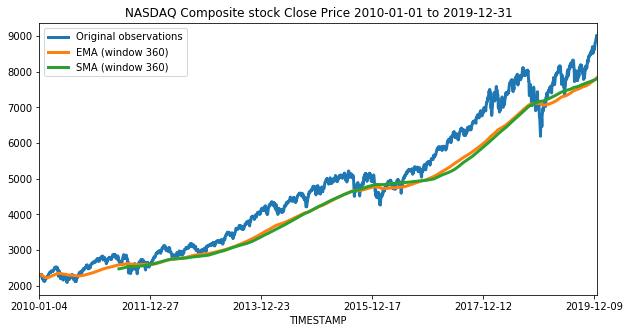

In [13]:
# Exponential Moving Average
exp_weighted_mean = close.ewm(span=360).mean()
sma_d10 = close.rolling(window=360).mean()
ax = close.plot(lw=3, figsize=(10, 5), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 360)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 360)')
plt.title('NASDAQ Composite stock Close Price 2010-01-01 to 2019-12-31')
plt.legend(loc='best')
plt.show()

From the above chart, you can see EMA in orange line catches the downwards movement in Dec 2015 and Dec 2018 faster than SMA in green line. And also at early 2016, EMA started to catch upwards movement, while SMA still showing downwards trend.

In [14]:
# Generate more features for prediction from Exponential Moving Average
df['EMA120'] = df['IXIC.Close'].ewm(span=120, adjust=False).mean()
df['EMA360'] = df['IXIC.Close'].ewm(span=360, adjust=False).mean()

df['dist_EMA120'] = (df['IXIC.Close'] - df['EMA120'])/df['EMA120']*100
df['dist_EMA360'] = (df['IXIC.Close'] - df['EMA360'])/df['EMA360']*100

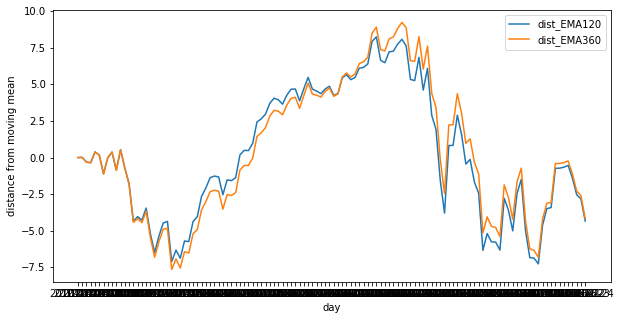

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df.index[:120], df['dist_EMA120'][:120], label='dist_EMA120')
ax.plot(df.index[:120], df['dist_EMA360'][:120], label='dist_EMA360')
ax.set_xlabel('day')
ax.set_ylabel('distance from moving mean')
ax.legend(loc='best')

# LSTM Data Preparation

The first step is to prepare the dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the close stock price at the current day given all the features at the prior time step.

In [16]:
#features = ['IXIC.Open', 'IXIC.Close', 'IXIC.High', 'IXIC.Low', 'IXIC.Adjusted', 'IXIC.Volume',
#            'BAMLH0A0HYM2', 'dist_EMA120', 'dist_EMA360']
features = ['IXIC.Close', 'BAMLH0A0HYM2', 'IXIC.Volume', 'dist_EMA120', 'dist_EMA360']
# get data value
raw_values = df[features].values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(raw_values)

In [17]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
1   0.028041   0.412451   0.345895   0.637806   0.414783  0.028079
2   0.028079   0.407263   0.430620   0.638187   0.415118  0.027092
3   0.027092   0.390402   0.408391   0.628181   0.406309  0.026958
4   0.026958   0.372244   0.411634   0.626975   0.405153  0.029174
5   0.029174   0.370947   0.387437   0.649620   0.424995  0.028558


In [18]:
reframe_name = reframed.rename(columns={'var1(t-1)': 'price(t-1)', 'var2(t-1)': 'rate(t-1)', 
                                        'var3(t-1)': 'volume(t-1)', 'var4(t-1)': 'dEMA120(t-1)', 
                                        'var5(t-1)': 'dEMA360(t-1)', 'var1(t)': 'price(t)'})
print(reframe_name.head())

   price(t-1)  rate(t-1)  volume(t-1)  dEMA120(t-1)  dEMA360(t-1)  price(t)
1    0.028041   0.412451     0.345895      0.637806      0.414783  0.028079
2    0.028079   0.407263     0.430620      0.638187      0.415118  0.027092
3    0.027092   0.390402     0.408391      0.628181      0.406309  0.026958
4    0.026958   0.372244     0.411634      0.626975      0.405153  0.029174
5    0.029174   0.370947     0.387437      0.649620      0.424995  0.028558


In [19]:
# split into train and test sets
values = reframed.values
train = values[0:2263, :]
test = values[2264:-77, :]
valid = values[-77:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_valid.shape, y_valid.shape)

(2263, 1, 5) (2263,) (251, 1, 5) (251,) (77, 1, 5) (77,)


Now we can define and fit our LSTM model.

We will define the LSTM with 64 neurons in the first hidden layer and 1 neuron in the output layer for predicting close stock price. The input shape will be 1 time step with 5 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 100 training epochs with a batch size of 128. 

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [20]:
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 17,985
Trainable params: 17,985
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
import random
random.seed(777)
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mean_squared_error'])
history = model.fit(X_train, y_train, epochs=100, batch_size = 128, 
                    validation_data=(X_test, y_test), shuffle=False)

Train on 2263 samples, validate on 251 samples
Epoch 1/100
2263/2263 [==============================] - 0s 178us/step - loss: 0.0734 - mean_squared_error: 0.0734 - val_loss: 0.3337 - val_mean_squared_error: 0.3337
Epoch 2/100
2263/2263 [==============================] - 0s 17us/step - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.2144 - val_mean_squared_error: 0.2144
Epoch 3/100
2263/2263 [==============================] - 0s 16us/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.1712 - val_mean_squared_error: 0.1712
Epoch 4/100
2263/2263 [==============================] - 0s 15us/step - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.1582 - val_mean_squared_error: 0.1582
Epoch 5/100
2263/2263 [==============================] - 0s 15us/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.1499 - val_mean_squared_error: 0.1499
Epoch 6/100
2263/2263 [==============================] - 0s 18us/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_lo

2263/2263 [==============================] - 0s 12us/step - loss: 3.6226e-04 - mean_squared_error: 3.6226e-04 - val_loss: 2.4183e-04 - val_mean_squared_error: 2.4183e-04
Epoch 49/100
2263/2263 [==============================] - 0s 13us/step - loss: 3.4375e-04 - mean_squared_error: 3.4375e-04 - val_loss: 2.3106e-04 - val_mean_squared_error: 2.3106e-04
Epoch 50/100
2263/2263 [==============================] - 0s 12us/step - loss: 3.2650e-04 - mean_squared_error: 3.2650e-04 - val_loss: 2.2166e-04 - val_mean_squared_error: 2.2166e-04
Epoch 51/100
2263/2263 [==============================] - 0s 12us/step - loss: 3.1037e-04 - mean_squared_error: 3.1037e-04 - val_loss: 2.1341e-04 - val_mean_squared_error: 2.1341e-04
Epoch 52/100
2263/2263 [==============================] - 0s 12us/step - loss: 2.9527e-04 - mean_squared_error: 2.9527e-04 - val_loss: 2.0615e-04 - val_mean_squared_error: 2.0615e-04
Epoch 53/100
2263/2263 [==============================] - 0s 12us/step - loss: 2.8110e-04 - mean_s

Epoch 93/100
2263/2263 [==============================] - 0s 12us/step - loss: 8.6698e-05 - mean_squared_error: 8.6698e-05 - val_loss: 1.5389e-04 - val_mean_squared_error: 1.5389e-04
Epoch 94/100
2263/2263 [==============================] - 0s 11us/step - loss: 8.5715e-05 - mean_squared_error: 8.5715e-05 - val_loss: 1.5387e-04 - val_mean_squared_error: 1.5387e-04
Epoch 95/100
2263/2263 [==============================] - 0s 11us/step - loss: 8.4778e-05 - mean_squared_error: 8.4778e-05 - val_loss: 1.5384e-04 - val_mean_squared_error: 1.5384e-04
Epoch 96/100
2263/2263 [==============================] - 0s 11us/step - loss: 8.3883e-05 - mean_squared_error: 8.3883e-05 - val_loss: 1.5380e-04 - val_mean_squared_error: 1.5380e-04
Epoch 97/100
2263/2263 [==============================] - 0s 12us/step - loss: 8.3025e-05 - mean_squared_error: 8.3025e-05 - val_loss: 1.5374e-04 - val_mean_squared_error: 1.5374e-04
Epoch 98/100
2263/2263 [==============================] - 0s 12us/step - loss: 8.2203

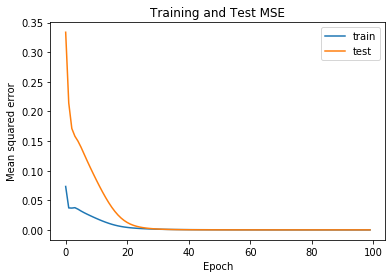

In [22]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training and Test MSE")
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')

plt.legend()
plt.show()

In [23]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], sqrt(testScore[0])))

Train Score: 0.00008 MSE (0.01 RMSE)
Test Score: 0.00015 MSE (0.01 RMSE)


In [24]:
# make a prediction
yhat =  model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 95.717


In [25]:
from sklearn.metrics import r2_score
print(r2_score(y_test, yhat))

0.9572842564338213


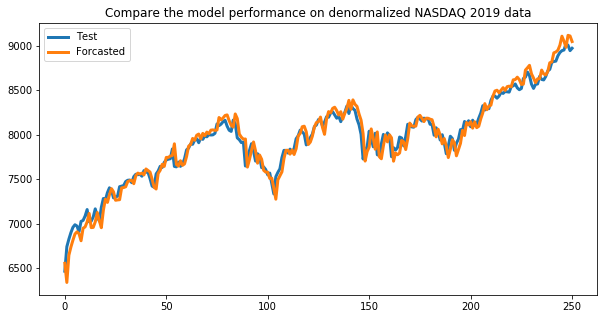

In [26]:
plt.figure(figsize=(10,5))
plt.plot(inv_y, linewidth=3)
plt.plot(inv_yhat, linewidth=3)
plt.title('Compare the model performance on denormalized NASDAQ 2019 data')
plt.legend(('Test','Forcasted'))
plt.show()

Only Close price without differencing: RMSE 151.7517841960049

Only Close price with differencing (and converted back): RMSE 77.03170345352157

Close price w/ interest rate: RMSE 125.86404728779044

Close price w/ interest rate and volumn: RMSE 109.70432917520674

Close price w/ interest rate, volumn, dist_EMA120, dist_EMA360: RMSE 94.7968443156603

Close price w/ all: RMSE 99.76379522424541

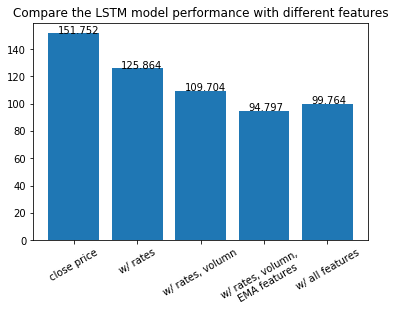

In [27]:
x = np.arange(5)
RMSE_list = [151.7517841960049, 125.86404728779044, 109.70432917520674, 94.7968443156603, 99.76379522424541]
plt.bar(x, RMSE_list)
plt.xticks(x, ('close price', 'w/ rates', 'w/ rates, volumn', 
               'w/ rates, volumn, \n EMA features', 'w/ all features'), rotation=30)
for i, v in enumerate(RMSE_list):
    plt.text(x[i] - 0.25, v + 0.01, str(round(v,3)))
plt.title('Compare the LSTM model performance with different features')
plt.show()

In [28]:
# make a prediction
yhat_2020 =  model.predict(X_valid)
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[2]))
# invert scaling for forecast
inv_yhat_2020 = np.concatenate((yhat_2020, X_valid[:, 1:]), axis=1)
inv_yhat_2020 = scaler.inverse_transform(inv_yhat_2020)
inv_yhat_2020 = inv_yhat_2020[:,0]
# invert scaling for actual
y_valid = y_valid.reshape((len(y_valid), 1))
inv_y_2020 = np.concatenate((y_valid, X_valid[:, 1:]), axis=1)
inv_y_2020 = scaler.inverse_transform(inv_y_2020)
inv_y_2020 = inv_y_2020[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_2020, inv_yhat_2020))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 328.522


In [29]:
print(r2_score(y_valid, yhat_2020))

0.8492977875518308


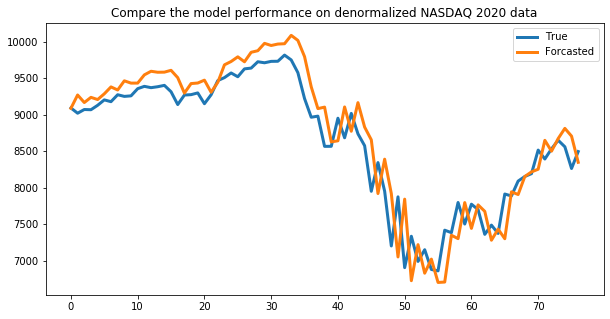

In [30]:
plt.figure(figsize=(10,5))
plt.plot(inv_y_2020, linewidth=3)
plt.plot(inv_yhat_2020, linewidth=3)
plt.title('Compare the model performance on denormalized NASDAQ 2020 data')
plt.legend(('True','Forcasted'))
plt.show()

In [31]:
pred_df = pd.DataFrame(inv_yhat)
pred_df.to_csv(r'lstm_pred.csv')